In [1]:
import glob
import matplotlib
import matplotlib.pyplot as plt
import pickle
import lmfit
import numpy as np
import scipy.stats as ss
plt.style.use('seaborn-white')
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.formula.api import ols, rlm
import sys
sys.path.append('../')
from Linearity import Neuron

In [2]:
#Colorscheme for squares
color_sqr = { index+1: color for index, color in enumerate(matplotlib.cm.viridis(np.linspace(0,1,9)))}

In [3]:
currentClampFiles = '/media/sahil/NCBS_Shares_BGStim/patch_data/current_clamp_files_with_GABAzine.txt'
with open (currentClampFiles,'r') as r:
    dirnames = r.read().splitlines()

In [4]:
feature = 0
scalingFactor = 1e9
neurons = {}
for dirname in dirnames:
    cellIndex = dirname.split('/')[-2]
    filename = dirname + 'plots/' + cellIndex + '.pkl'
    n = Neuron.load(filename)
    neurons[str(n.date) + '_' + str(n.index)] = n

In [5]:
control_result2_rsquared_adj = []
control_result1_rsquared_adj = []
control_var_expected = []
gabazine_result2_rsquared_adj = []
gabazine_result1_rsquared_adj = []
gabazine_var_expected = []
tolerance = 5e-4

In [43]:
def simpleaxis(axes, every=False, outward=True):
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if (outward):
            ax.spines['bottom'].set_position(('outward', 10))
            ax.spines['left'].set_position(('outward', 10))
        if every:
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_title('')

In [7]:
def linearModel(x, beta=1):
    # Linear model
    return (beta*x)

def DN_model(x, beta=100, gamma=100):
    # Divisive normalization model
    #return x - a*(x**2)/(b+x)
    return ((x**2)*(1-beta) + (gamma*x))/(x+gamma)

In [47]:
lin_aic = []
dn_aic = []
lin_chi = []
dn_chi = []

control_observed = {}
control_observed_average = {}
gabazine_observed ={}
gabazine_observed_average = {}
control_expected = {}
control_expected_average = {}
gabazine_expected ={}
gabazine_expected_average = {}
feature = 0

neuron = neurons['161013_c1']

In [48]:
# neuron.features

## 5 A (GABAzine treatment abolishes divisive normalization)

In [53]:
feature = 0
expected, observed, g_expected, g_observed = {}, {}, {}, {}
for expType, exp in neuron:
    ## Control case
    if expType == "Control":
        for sqr in exp:
                if sqr > 1:
                    expected[sqr] = []
                    observed[sqr] = []
                    for coord in exp[sqr].coordwise:
                        for trial in exp[sqr].coordwise[coord].trials:
                            if all([value == 0 for value in trial.flags.values()]):
                                expected[sqr].append(exp[sqr].coordwise[coord].expected_feature[feature])
                                observed[sqr].append(trial.feature[feature])
    ## Gabazine case
    if(expType == "GABAzine"):
        for sqr in exp:
            if sqr > 1:
                g_expected[sqr] = []
                g_observed[sqr] = []
                for coord in exp[sqr].coordwise:
                    for trial in exp[sqr].coordwise[coord].trials:
                        if all([value == 0 for value in trial.flags.values()]):
                            g_expected[sqr].append(exp[sqr].coordwise[coord].expected_feature[feature])
                            g_observed[sqr].append(trial.feature[feature])

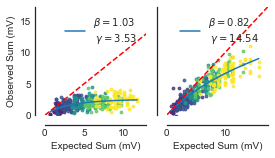

In [81]:
f, ax = plt.subplots(1,2, sharey=True)

## Control stuff
squareVal = []
list_control_expected = []
list_control_observed = []

max_exp, max_g_exp = 0.,0.
for sqr in sorted(observed):
    squareVal.append(ax[0].scatter(expected[sqr], observed[sqr], label=str(sqr), c=color_sqr[sqr], alpha=0.8, s=8))
    max_exp = max(max_exp, max(expected[sqr]))
    list_control_expected += expected[sqr]
    list_control_observed += observed[sqr]
    
X = np.array(list_control_expected)
y = np.array(list_control_observed)
idx   = np.argsort(X)
X = X[idx]
y = y[idx]

linear_Model = lmfit.Model(linearModel)
DN_Model = lmfit.Model(DN_model)

lin_pars = linear_Model.make_params()
lin_result = linear_Model.fit(y, lin_pars, x=X)
lin_aic.append(lin_result.aic)
lin_chi.append(lin_result.redchi)

DN_pars = DN_Model.make_params()
DN_result = DN_Model.fit(y, DN_pars, x=X)
dn_aic.append(DN_result.aic)
dn_chi.append(DN_result.redchi)

# print (lin_result.fit_report())
# print (DN_result.fit_report())

ax[0].set_xlim(xmin=0.)
ax[0].set_ylim(ymin=0.)
ax[0].set_xlabel("Expected")
ax[0].set_ylabel("Observed")
ax[0].set_title("Divisive Normalization fits")
div_norm = ax[0].plot(X, DN_result.best_fit, '-')


max_exp *=1.1
max_g_exp *=1.1
ax[0].set_xlim(0,max_exp)
ax[0].set_ylim(0,max_exp)
ax[0].set_xlabel("Expected Sum (mV)")
ax[0].set_ylabel("Observed Sum (mV)")
linear = ax[0].plot((0,max_exp), (0,max_exp), 'r--')

legends = div_norm
labels = [ "$\\beta={:.2f}$ \n $ \\gamma={:.2f}$".format(DN_result.params['beta'].value, DN_result.params['gamma'].value)]
ax[0].legend(legends, labels)


### GABAzine stuff 
squareVal = []
list_gabazine_expected = []
list_gabazine_observed = []

max_exp, max_g_exp = 0.,0.
for sqr in sorted(g_observed):
    squareVal.append(ax[1].scatter(g_expected[sqr], g_observed[sqr], label=str(sqr), c=color_sqr[sqr], alpha=0.8, s=8))
    max_exp = max(max_exp, max(g_expected[sqr]))
    list_gabazine_expected += g_expected[sqr]
    list_gabazine_observed += g_observed[sqr]
    
X = np.array(list_gabazine_expected)
y = np.array(list_gabazine_observed)
idx   = np.argsort(X)
X = X[idx]
y = y[idx]

linear_Model = lmfit.Model(linearModel)
DN_Model = lmfit.Model(DN_model)

lin_pars = linear_Model.make_params()
lin_result = linear_Model.fit(y, lin_pars, x=X)
lin_aic.append(lin_result.aic)
lin_chi.append(lin_result.redchi)

DN_pars = DN_Model.make_params()
DN_result = DN_Model.fit(y, DN_pars, x=X)
dn_aic.append(DN_result.aic)
dn_chi.append(DN_result.redchi)

# print (lin_result.fit_report())
# print (DN_result.fit_report())

ax[1].set_xlim(xmin=0.)
ax[1].set_ylim(ymin=0.)
ax[1].set_title("Divisive Normalization fits")
div_norm = ax[1].plot(X, DN_result.best_fit, '-')


max_exp *=1.1
max_g_exp *=1.1
ax[1].set_xlim(0,max_exp)
ax[1].set_ylim(0,max_exp)
ax[1].set_xlabel("Expected Sum (mV)")
# ax[1].set_ylabel("Observed Sum (mV)")
linear = ax[1].plot((0,max_exp), (0,max_exp), 'r--')

legends = div_norm
labels = [ "$\\beta={:.2f}$ \n $\\gamma={:.2f}$".format(DN_result.params['beta'].value, DN_result.params['gamma'].value)]
ax[1].legend(legends, labels)
ax[1].yaxis.set_visible(False)
simpleaxis(ax)
f.set_figwidth(4)
f.set_figheight(2)
plt.show()

## 5 C Gabazine - Control responses are still balanced

In [51]:
feature = 0
#expected, observed, g_expected, g_observed = {}, {}, {}, {}
control, gabazine = {}, {}
for expType, exp in neuron:
    ## Control case
    if(expType == "Control"):
        for sqr in exp:
            if sqr > 1:
                expected[sqr] = []
                observed[sqr] = []
                for coord in exp[sqr].coordwise:
                    if all([value == 0 for value in exp[sqr].coordwise[coord].flags.values()]):
                        control[sqr] = exp[sqr]
    ## Gabazine case
    if(expType == "GABAzine"):
        for sqr in exp:
            if sqr > 1:
                g_expected[sqr] = []
                g_observed[sqr] = []
                for coord in exp[sqr].coordwise:
                    if all([value == 0 for value in exp[sqr].coordwise[coord].flags.values()]):
                        gabazine[sqr] = exp[sqr]

derived_inh, exc = {}, {}
for sq in set(control).intersection(set(gabazine)):
    derived_inh[sq] = []
    exc[sq] = []
    for coord in set(control[sq].coordwise).intersection(set(gabazine[sq].coordwise)):
        derived_inh[sq].append(gabazine[sq].coordwise[coord].average_feature[feature] - control[sq].coordwise[coord].average_feature[feature])
        exc[sq].append(gabazine[sq].coordwise[coord].average_feature[feature])

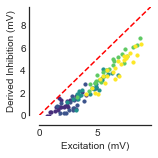

In [38]:
### Derived Inh
squareVal = []
list_exc = []
list_inh = []
f, ax = plt.subplots()
max_exp, max_g_exp = 0.,0.
for sqr in sorted(derived_inh):
    squareVal.append(ax.scatter(exc[sqr], derived_inh[sqr], label=str(sqr), c=color_sqr[sqr], s=10))
    max_exp = max(max_exp, max(exc[sqr]))
    
max_exp *=1.1
max_g_exp *=1.1
ax.set_xlim(0,max_exp)
ax.set_ylim(0,max_exp)
ax.set_xlabel("Excitation (mV)")
ax.set_ylabel("Derived Inhibition (mV)")
linear = ax.plot((0,max_exp), (0,max_exp), 'r--')

legends = squareVal + linear
labels = sorted(observed.keys()) + [ "Linear sum"]
# ax.legend(legends, labels)

f.set_figwidth(2)
f.set_figheight(2)
simpleaxis(ax)
plt.show()

## 5 D (Comparing Gabazine and Control DN fit parameters) : 3 neurons have an error. Check what's happening

In [28]:
neurons.pop('161027_c3', None)
neurons.pop('160817_c4', None)
neurons.pop('160927_c5', None)

<Linearity.Neuron instance at 0x7fdb40a505a8>

In [29]:
feature = 0
DN_Control = []
DN_GABAzine = []

for index in neurons:
#     print (index)
    neuron = neurons[index]
    expected, observed, g_expected, g_observed = {}, {}, {}, {}
    for expType, exp in neuron:
        ## Control case
        if expType == "Control":
            for sqr in exp:
                    if sqr > 1:
                        expected[sqr] = []
                        observed[sqr] = []
                        for coord in exp[sqr].coordwise:
                            for trial in exp[sqr].coordwise[coord].trials:
                                if all([value == 0 for value in trial.flags.values()]):
                                    expected[sqr].append(exp[sqr].coordwise[coord].expected_feature[feature])
                                    observed[sqr].append(trial.feature[feature])
        ## Gabazine case
        if(expType == "GABAzine"):
            for sqr in exp:
                if sqr > 1:
                    g_expected[sqr] = []
                    g_observed[sqr] = []
                    for coord in exp[sqr].coordwise:
                        for trial in exp[sqr].coordwise[coord].trials:
                            if all([value == 0 for value in trial.flags.values()]):
                                g_expected[sqr].append(exp[sqr].coordwise[coord].expected_feature[feature])
                                g_observed[sqr].append(trial.feature[feature])
       
    ## Control stuff
    squareVal = []
    list_control_expected = []
    list_control_observed = []

    max_exp, max_g_exp = 0.,0.
    for sqr in sorted(observed):
        list_control_expected += expected[sqr]
        list_control_observed += observed[sqr]

    X = np.array(list_control_expected)
    y = np.array(list_control_observed)
    idx   = np.argsort(X)
    X = X[idx]
    y = y[idx]

    DN_Model = lmfit.Model(DN_model)
    DN_pars = DN_Model.make_params()
    DN_result = DN_Model.fit(y, DN_pars, x=X)   
    DN_Control.append((DN_result.params['beta'], DN_result.params['gamma'], DN_result.redchi))

    ### GABAzine stuff 
    squareVal = []
    list_gabazine_expected = []
    list_gabazine_observed = []
    
    del DN_Model
    
    max_exp, max_g_exp = 0.,0.
    for sqr in sorted(g_observed):
        list_gabazine_expected += g_expected[sqr]
        list_gabazine_observed += g_observed[sqr]

    X = np.array(list_gabazine_expected)
    y = np.array(list_gabazine_observed)
    idx   = np.argsort(X)
    X = X[idx]
    y = y[idx]

    DN_Model = lmfit.Model(DN_model)
    DN_pars = DN_Model.make_params()
    DN_result = DN_Model.fit(y, DN_pars, x=X)
    DN_GABAzine.append((DN_result.params['beta'], DN_result.params['gamma'],DN_result.redchi))

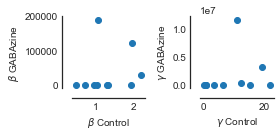

In [93]:
fig, ax = plt.subplots(1, 2)
dn_beta, dn_gamma, dn_chi = map(list, zip(*DN_Control))
gaba_beta, gaba_gamma, gaba_chi = map(list, zip(*DN_GABAzine))
ax[0].scatter(dn_beta, gaba_beta)
ax[1].scatter(dn_gamma, gaba_gamma)

# ax.plot([0,3],[0,3],'--')
# ax.set_xlim(0,3)
# ax.set_ylim(0,3)
ax[0].set_xlabel("$\\beta$ Control")
ax[0].set_ylabel("$\\beta$ GABAzine")
ax[1].set_xlabel("$\\gamma$ Control")
ax[1].set_ylabel("$\\gamma$ GABAzine")
simpleaxis(ax)
fig.set_figwidth(4)
fig.set_figheight(2)
fig.tight_layout()
plt.show()

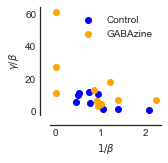

In [98]:
fig, ax = plt.subplots()
dn_beta, dn_gamma, gaba_beta, gaba_gamma = np.array(dn_beta), np.array(dn_gamma), np.array(gaba_beta), np.array(gaba_gamma)
ax.scatter(1./dn_beta, dn_gamma/dn_beta, c='b', label="Control")
ax.scatter(1./gaba_beta, gaba_gamma/gaba_beta, c='orange', label="GABAzine")
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(0,20)
# ax.set_ylim(0,20)
ax.set_xlabel("$1/\\beta$")
ax.set_ylabel("$\\gamma/\\beta$")
simpleaxis(ax)
fig.set_figheight(2)
fig.set_figwidth(2)
ax.legend(loc='best')
plt.show()

In [89]:
# indices = [1,2]
# fig, ax = plt.subplots()

# for ind, (l,d) in enumerate(zip(gaba_chi, dn_chi)):
#     ax.plot(indices, [l,d], 'o-', alpha=0.4, color='0.5', markerfacecolor='white')
# # ax.violinplot([lin_chi,dn_chi], indices)

# # notch shape box plot
# bplot = ax.boxplot([gaba_chi,dn_chi],
#                          notch=True,  # notch shape
#                          vert=True,   # vertical box aligmnent
#                          patch_artist=True)   # fill with color

# colors = ['green', 'purple']
# for patch, color in zip(bplot['boxes'], colors):
#     patch.set_facecolor(color)

# ax.hlines(1, 0,3, linestyles='--', alpha=0.6)
# # ax.boxplot(, [1])

# # ax.set_xlim((-1,2))
# ax.set_ylim((-1,7))
# ax.set_xticks(indices)
# ax.set_xticklabels(('GABAzine', 'Control'))
# ax.set_title("Reduced chi-square values for GABAzine and Control")
# simpleaxis(ax)

# print(ss.ttest_rel(gaba_chi, dn_chi))

# y, h, col = np.max(gaba_chi), 0.5, 'k'
# plt.plot([1,1, 2, 2], [y, y+h, y+h, y], lw=1.5, c=col)
# plt.text((1+2)*.5, y+h, "***", ha='center', va='bottom', color=col)

# fig.set_figwidth(3)
# fig.set_figheight(3)
# plt.show()

In [ ]:
# f, ax = plt.subplots()
# bins = np.linspace(0,1,15)
# ax.hist(DN_Control,bins=bins,color='b')
# ax.hist(DN_GABAzine,bins=bins,color='g')
# plt.show()

In [ ]:
##  Stuff I'm not using.

In [ ]:
# list_control_observed   = []  
# list_gabazine_observed  = []
# list_control_expected   = []
# list_gabazine_expected  = []

# if len(gabazine_observed):
#     for key in gabazine_observed.keys():
#         for element1, element2 in zip(gabazine_observed[key], gabazine_expected[key] ):
#             if not (element1 <0 or np.isclose(element1, 0, atol=tolerance) or element2<0 or np.isclose(element2, 0, atol=tolerance)):
#                 list_gabazine_observed.append(element1)
#                 list_gabazine_expected.append(element2)

# if len(control_observed):
#     for key in control_observed.keys():
#         for element1, element2 in zip(control_observed[key], control_expected[key] ):
#             if not (element1 <0 or np.isclose(element1, 0, atol=tolerance) or element2<0 or np.isclose(element2, 0, atol=tolerance)):
#                 list_control_observed.append(element1)
#                 list_control_expected.append(element2)

In [ ]:
# minPoints = 10
# minIQR = 3
# if len(list_control_expected)>minPoints and len(list_control_observed)> minPoints and ss.iqr(list_control_expected)>minIQR:
#     print ("Control")
#     X = np.array(list_control_expected)
#     y = np.array(list_control_observed)
#     idx   = np.argsort(X)
#     X = X[idx]
#     y = y[idx]

#     linear_Model = lmfit.Model(linearModel)
#     DN_Model = lmfit.Model(DN_model)

#     lin_pars = linear_Model.make_params()
#     lin_result = linear_Model.fit(y, lin_pars, x=X)
#     lin_aic.append(lin_result.aic)
#     lin_chi.append(lin_result.redchi)

#     DN_pars = DN_Model.make_params()
#     DN_result = DN_Model.fit(y, DN_pars, x=X)
#     dn_aic.append(DN_result.aic)
#     dn_chi.append(DN_result.redchi)

#     print (lin_result.fit_report())
#     print (DN_result.fit_report())

#     ax = plt.subplot(111)
#     ax.scatter(X, y, alpha=0.2)
#     ax.set_xlim(xmin=0.)
#     ax.set_ylim(ymin=0.)
#     ax.set_xlabel("Expected")
#     ax.set_ylabel("Observed")
#     ax.set_title("Divisive Normalization and Inhibition fits")
#     ax.plot(X, lin_result.best_fit, '-', label="Divisive Inhibition Model")
#     ax.plot(X, DN_result.best_fit, '-', label="Divisive Normalization Model")
#     plt.legend()
#     plt.show()

In [ ]:
# if len(list_gabazine_expected)>minPoints and len(list_gabazine_observed)>minPoints and ss.iqr(list_gabazine_expected)>minIQR :

#     print ("GABAzine")
#     X = np.array(list_gabazine_expected)
#     y = np.array(list_gabazine_observed)
    
#     idx   = np.argsort(X)
#     X = X[idx]
#     y = y[idx]

#     linear_Model = lmfit.Model(linearModel)
#     DN_Model = lmfit.Model(DN_model)

#     lin_pars = linear_Model.make_params()
#     lin_result = linear_Model.fit(y, lin_pars, x=X)
#     lin_aic.append(lin_result.aic)
#     lin_chi.append(lin_result.redchi)

#     DN_pars = DN_Model.make_params()
#     DN_result = DN_Model.fit(y, DN_pars, x=X)
#     dn_aic.append(DN_result.aic)
#     dn_chi.append(DN_result.redchi)

#     print (lin_result.fit_report())
#     print (DN_result.fit_report())

#     ax = plt.subplot(111)
#     ax.scatter(X, y, alpha=0.2)
#     ax.set_xlim(xmin=0.)
#     ax.set_ylim(ymin=0.)
#     ax.set_xlabel("Expected")
#     ax.set_ylabel("Observed")
#     ax.set_title("Divisive Normalization and Inhibition fits")
#     ax.plot(X, lin_result.best_fit, '-', label="Divisive Inhibition Model")
#     ax.plot(X, DN_result.best_fit, '-', label="Divisive Normalization Model")
#     plt.legend()
#     plt.show()

In [ ]:
### GABAzine plotted with control

In [ ]:
# list_control_observed   = []  
# list_gabazine_observed  = []
# list_control_expected   = []
# list_gabazine_expected  = []

# if len(gabazine_observed_average) and len(control_observed_average):
#     for key in list(set(gabazine_observed_average).intersection(set(control_observed_average))):
#         element1, element2 =  gabazine_observed_average[key], control_observed_average[key]
#         if not (element1 <0 or np.isclose(element1, 0, atol=tolerance) or element2<0 or np.isclose(element2, 0, atol=tolerance)):
#             list_gabazine_observed.append(element1)
#             list_control_observed.append(element2)

In [ ]:
# print ("GABAzine and control")
# #X = np.array(list_gabazine_expected)
# #y = np.array(list_gabazine_observed)

# y = np.array(list_control_observed)
# X = np.array(list_gabazine_observed)

# idx   = np.argsort(X)
# X = X[idx]
# y = y[idx]

# linear_Model = lmfit.Model(linearModel)
# DN_Model = lmfit.Model(DN_model)

# lin_pars = linear_Model.make_params()
# lin_result = linear_Model.fit(y, lin_pars, x=X)
# lin_aic.append(lin_result.aic)
# lin_chi.append(lin_result.redchi)

# DN_pars = DN_Model.make_params()
# DN_result = DN_Model.fit(y, DN_pars, x=X)
# dn_aic.append(DN_result.aic)
# dn_chi.append(DN_result.redchi)

# print (lin_result.fit_report())
# print (DN_result.fit_report())

# ax = plt.subplot(111)
# ax.scatter(X, y, alpha=0.2)
# ax.set_xlim(xmin=0.)
# ax.set_ylim(ymin=0.)
# ax.set_xlabel("Expected")
# ax.set_ylabel("Observed")
# ax.set_title("Divisive Normalization and Inhibition fits")
# ax.plot(X, lin_result.best_fit, '-', label="Divisive Inhibition Model")
# ax.plot(X, DN_result.best_fit, '-', label="Divisive Normalization Model")
# plt.show()

In [ ]:
### For averaged out responses

In [ ]:
# for expt in neuron.experiment:
#     print ("Starting expt {}".format(expt))
#     for numSquares in neuron.experiment[expt].keys(): 
#         print ("Square {}".format(numSquares))
#         if not numSquares == 1:
#             nSquareData = neuron.experiment[expt][numSquares]
#             if expt == "Control":
#                 coords_C = nSquareData.coordwise
#                 for coord in coords_C: 
#                     if feature in coords_C[coord].feature:
#                         control_observed_average.update({coord: coords_C[coord].average_feature[feature]})
#                         control_expected_average.update({coord: coords_C[coord].expected_feature[feature]})
#                         control_observed.update({coord: []})
#                         control_expected.update({coord: []})
#                         for trial in coords_C[coord].trials:
#                             if feature in trial.feature:
#                                 control_observed[coord].append(trial.feature[feature])
#                                 control_expected[coord].append(coords_C[coord].expected_feature[feature])
#             elif expt == "GABAzine":
#                 coords_I = nSquareData.coordwise
#                 for coord in coords_I: 
#                     if feature in coords_I[coord].feature:
#                         gabazine_observed.update({coord: []})
#                         gabazine_expected.update({coord: []})
#                         gabazine_observed_average.update({coord: coords_I[coord].average_feature[feature]})
#                         gabazine_expected_average.update({coord: coords_I[coord].expected_feature[feature]})

#                         for trial in coords_I[coord].trials:
#                             if feature in trial.feature:
#                                 gabazine_observed[coord].append(trial.feature[feature])
#                                 gabazine_expected[coord].append(coords_I[coord].expected_feature[feature])
# print ("Read {} into variables".format(filename))

In [ ]:
# list_control_observed   = []  
# list_gabazine_observed  = []
# list_control_expected   = []
# list_gabazine_expected  = []

# if len(gabazine_observed_average):
#     for key in gabazine_observed_average.keys():
#         element1, element2 = gabazine_observed_average[key], gabazine_expected_average[key]
#         if not (element1 <0 or np.isclose(element1, 0, atol=tolerance) or element2<0 or np.isclose(element2, 0, atol=tolerance)):
#             list_gabazine_observed.append(element1)
#             list_gabazine_expected.append(element2)

# if len(control_observed_average):
#     for key in control_observed_average.keys():
#         element1, element2 = control_observed_average[key], control_expected_average[key]
#         if not (element1 <0 or np.isclose(element1, 0, atol=tolerance) or element2<0 or np.isclose(element2, 0, atol=tolerance)):
#             list_control_observed.append(element1)
#             list_control_expected.append(element2)